In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tomato-custom-dataset/Plant/Late_blight/112.brightened.jpg
/kaggle/input/tomato-custom-dataset/Plant/Late_blight/191.adjusted.jpg
/kaggle/input/tomato-custom-dataset/Plant/Late_blight/121.adjusted.jpg
/kaggle/input/tomato-custom-dataset/Plant/Late_blight/253.flipped.jpg
/kaggle/input/tomato-custom-dataset/Plant/Late_blight/167.flipped.jpg
/kaggle/input/tomato-custom-dataset/Plant/Late_blight/380.flipped.jpg
/kaggle/input/tomato-custom-dataset/Plant/Late_blight/208.jpg
/kaggle/input/tomato-custom-dataset/Plant/Late_blight/59_rotated.jpg
/kaggle/input/tomato-custom-dataset/Plant/Late_blight/67.adjusted.jpg
/kaggle/input/tomato-custom-dataset/Plant/Late_blight/241.adjusted.jpg
/kaggle/input/tomato-custom-dataset/Plant/Late_blight/17.adjusted.jpg
/kaggle/input/tomato-custom-dataset/Plant/Late_blight/40.flipped.jpg
/kaggle/input/tomato-custom-dataset/Plant/Late_blight/148.brightened.jpg
/kaggle/input/tomato-custom-dataset/Plant/Late_blight/243.flipped.jpg
/kaggle/input/tomato-

In [2]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Torch
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

# Pillow
from PIL import Image
import pickle

In [3]:
class PlantImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.classes = []
        self.img_labels = []
        self.img_fnames = []
        for folder in os.listdir(root):
            self.classes.append(folder)
            folder_path = os.path.join(root, folder)
            for file in os.listdir(folder_path):
                self.img_fnames.append(os.path.join(folder_path, file))
                self.img_labels.append(folder)
                
    def __getitem__(self, idx):
        try:
            # Load the image
            img = Image.open(self.img_fnames[idx]).convert('RGB')
            # Get the numerical label
            label = self.img_labels[idx]
            if self.transform:
                img = self.transform(img)

        except:
            # Return default values for unreadable files
            return None, -1
        return img, label
    def __len__(self):
        return len(self.img_fnames)

In [32]:
data_path = "/kaggle/input/tomato-custom-dataset/Plant"
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root=data_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


In [33]:
# Get the first batch of data
inputs, labels = next(iter(dataloader))

# Get the shape of the images
image_shape = inputs[0].shape

# Print the number of images and their shape
print(f"Number of images: {len(dataloader.dataset)}")
print(f"Image shape: {image_shape}")

Number of images: 14315
Image shape: torch.Size([3, 256, 256])


In [34]:
classes = dataloader.dataset.classes
classes

['Bacterial_spot',
 'Early_blight',
 'Healthy',
 'Late_blight',
 'Mosiac_virus',
 'Septoria_leaf_spot',
 'YellowLeaf_curl']

In [35]:
indices = list(range(len(dataset)))
split = int(np.floor(0.90 * len(dataset)))  # train_size
validation = int(np.floor(0.70 * split))   # validation
np.random.shuffle(indices)

print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")

length of train size :9018
length of validation size :3865
length of test size :5297


In [36]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

In [37]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [38]:
class Conv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        """
        This function initializes the parameters for a conv2D layer

        Parameters
        ------------
        in_channels : int
        Number of channels in the input image

        out_channels : int
        Number of channels produced by the convolution

        kernel_size : int or tuple
        Size of the convolving kernel 

        stride : int or tuple
        Stride of the convolution. Default: 1

        padding: int, tuple or str
        Padding added to all four sides of the input. Default: 'same'
        """
        super(Conv2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = stride
        self.padding = padding

        self.weight = nn.Parameter(
            torch.nn.init.xavier_uniform_(
                torch.empty(
                    (self.out_channels, self.in_channels, *self.kernel_size),
                    requires_grad=True
                )
            )
        )
        self.bias = nn.Parameter(
            torch.zeros((self.out_channels,), requires_grad=True)
        )

    def forward(self, x):
        """
        This function performs convolution operation on the input
        Parameters
        ------------
        x : tensor, float32
        Input image to the convolution layer

        Returns
        ------------
        x : tensor, float32
        feature map output from the last layer
        """
        x = F.conv2d(x,self.weight,self.bias,padding=self.padding,stride=self.stride)
        x = F.relu(x)
        return x
    


In [39]:

class MaxPool(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        """
        This function initializes the parameters for a maxpool layer

        Parameters
        ------------
        kernel_size : int
        window height and width for the maxpooling window

        stride : int
        the stride of the window. Default value is kernel_size

        padding: int
        implicit zero padding to be added on both sides
        """
        super(MaxPool, self).__init__()
        self.kernel_size = kernel_size
        self.stride = kernel_size if stride is None else stride
        self.padding = padding


    def forward(self, x): 
        """
        This function performs max-pool operation on the input

        Parameters
        ------------
        x : tensor, float32
        Input image to the convolution layer

        Returns
        ------------
        x : tensor, float32
        max-pooled output from the last layer
        """
        x = F.max_pool2d(x,kernel_size=self.kernel_size,padding=self.padding,
                         stride=self.stride)
        return x

In [40]:

class Dense(nn.Module):
    def __init__(self, in_features, out_features):
        """
        This function initializes the parameters for a dense layer
        Parameters
        ------------- 
        in_features : int
        shape of the input to the dense layer

        out_features : int
        number of units in the dense layer
        """
        super(Dense, self).__init__()
        self.in_features = in_features
        self.out_features =  out_features
        
        self.weight = nn.Parameter(
            torch.nn.init.xavier_uniform_(
                torch.empty(
                    (self.in_features, self.out_features),
                    requires_grad=True,
                )
            )
        )
        print(self.weight.shape)
        self.bias = nn.Parameter(
            torch.zeros((self.out_features,), requires_grad=True)
        )
        print(self.bias.shape)

    def forward(self, x):
        """
        This function performs dense operation on the input
        Parameters
        ------------
        x : tensor, float32
        Input flattened image to the convolution layer

        Returns
        ------------
        x : tensor, float32
        linear operation output from the last layer
        """
        x = torch.mm(x, self.weight) + self.bias
        return x


In [41]:
k = len(classes)
class CNNModel(nn.Module):
    def __init__(self):
        """
        This function initializes the layers for the CNN model
        """
        super(CNNModel, self).__init__()

        # parameters for conv layers
        filter_dim = 3
        in_channels = [3, 32, 64, 64, 64]
        out_channels = [32, 64, 64, 64,64]

        # parameters for dense layers
        dense_in_features = [64*8*8, 1024]
        dense_out_features = [1024, k]

        # initializing all the layers
        self.c1 = Conv2D(in_channels[0], out_channels[0], filter_dim)
        self.m1 = MaxPool(2)
        self.dropout = nn.Dropout(p=0.25)
        self.c2 = Conv2D(in_channels[1], out_channels[1], filter_dim)
        self.m2 = MaxPool(2)
        self.dropout = nn.Dropout(p=0.25)
        
        self.c3 = Conv2D(in_channels[2], out_channels[2], filter_dim)
        self.m3 = MaxPool(2)
        self.dropout = nn.Dropout(p=0.25)
        self.c4 = Conv2D(in_channels[3],out_channels[3],filter_dim)
        self.m4 = MaxPool(2)
        self.dropout = nn.Dropout(p=0.25)
        
        self.c5 = Conv2D(in_channels[4], out_channels[4], filter_dim)
        self.m5 = MaxPool(2)
        self.dropout = nn.Dropout(p=0.25)
        
        self.d1 = Dense(dense_in_features[0],dense_out_features[0])

        self.d2 = Dense(dense_in_features[1], dense_out_features[1])
        
    def forward(self,x):
        """
        This function performs convolutions, relu, max_pooling, dropout, 
        reshape and dense operations on the input to the model.

        Parameters
        ------------
        x : tensor, float32
        Input image to the model

        Returns
        ------------
        x : tensor, float32
        output from the last layer

        """
        x = self.c1(x)
        x = self.m1(x)
        x = self.dropout(x)
        
        x = self.c2(x)
        x = self.m2(x)
        x = self.dropout(x)
        
        x = self.c3(x)
        x = self.m3(x)
        x = self.dropout(x)
        
        x = self.c4(x)
        x = self.m5(x)
        x = self.dropout(x)
        
        x = self.c5(x)
        x = self.m3(x)
        x = self.dropout(x)
        
        #x = torch.flatten(x,-1)
        x = x.view(x.shape[0],-1)
        x = self.d1(x)
        x = F.relu(x)

        x = self.d2(x)

        return x

In [42]:
model = CNNModel()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

torch.Size([4096, 1024])
torch.Size([1024])
torch.Size([1024, 7])
torch.Size([7])


CNNModel(
  (c1): Conv2D()
  (m1): MaxPool()
  (dropout): Dropout(p=0.25, inplace=False)
  (c2): Conv2D()
  (m2): MaxPool()
  (c3): Conv2D()
  (m3): MaxPool()
  (c4): Conv2D()
  (m4): MaxPool()
  (c5): Conv2D()
  (m5): MaxPool()
  (d1): Dense()
  (d2): Dense()
)

In [43]:
x = torch.randn(149, 3, 256, 256)
x = x.to('cuda') # move input tensor to the GPU
x = model.c1(x)
x = model.m1(x)
x = model.dropout(x)

x = model.c2(x)
x = model.m2(x)
x = model.dropout(x)


x = model.c3(x)
x = model.m3(x)
x = model.dropout(x)

x = model.c4(x)
x = model.m4(x)
x = model.dropout(x)

x = model.c5(x)
x = model.m5(x)
x = model.dropout(x)


print(x.shape)  # output: torch.Size([149, 64, 8, 8])


torch.Size([149, 64, 8, 8])


In [24]:
!pip install torchsummary

In [44]:
from torchsummary import summary
summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2D-1         [-1, 32, 256, 256]             896
           MaxPool-2         [-1, 32, 128, 128]               0
           Dropout-3         [-1, 32, 128, 128]               0
            Conv2D-4         [-1, 64, 128, 128]          18,496
           MaxPool-5           [-1, 64, 64, 64]               0
           Dropout-6           [-1, 64, 64, 64]               0
            Conv2D-7           [-1, 64, 64, 64]          36,928
           MaxPool-8           [-1, 64, 32, 32]               0
           Dropout-9           [-1, 64, 32, 32]               0
           Conv2D-10           [-1, 64, 32, 32]          36,928
          MaxPool-11           [-1, 64, 16, 16]               0
          Dropout-12           [-1, 64, 16, 16]               0
           Conv2D-13           [-1, 64, 16, 16]          36,928
          MaxPool-14             [-1, 6

In [45]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [51]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())

In [46]:

def loss(target_y, predicted_y):
    """
    Cross entropy loss between target and predicted value
      
    Parameters
    ----------
    target_y: tensor, float32
    Target labels
    predicted_y: tensor, float32
    Prediction of the classes made by model
      
    Returns
    -------
    cost: tensor, float32
    The average cross-entropy cost of the mini-batch of inputs
      
    """
    cost = F.cross_entropy(predicted_y,target_y)
    return cost

In [47]:
def train(model: nn.Module, inputs, outputs, optimizer: torch.optim.Optimizer):
    # Set the model to training mode
    model.train()

    # Zero the gradients
    optimizer.zero_grad()

    # Compute the model's predictions
    predictions = model(inputs)

    # Compute the loss
    loss = nn.functional.cross_entropy(predictions, outputs)

    # Compute the gradients
    loss.backward()

    # Update the weights
    optimizer.step()

    return loss, predictions


In [52]:
num_epochs = 25

def train_model(model, train_loader, validation_loader, optimizer, loss, num_epochs, device,version):
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    
    print("------------------------Training--------------------------")
    
    for i in range(num_epochs):
        t0 = datetime.now()
        train_loss = []
        train_acc = []
        model.train()
        for num, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            losses, pred = train(model, x_batch, y_batch, optimizer) 
            train_loss.append(losses.item())
            train_acc.append((y_batch == pred.argmax(dim=-1)).float().mean().item())

        test_loss = []
        test_acc = []
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in validation_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                test_pred = model(x_batch)
                test_loss.append(loss(y_batch, test_pred).item())
                test_acc.append((y_batch == test_pred.argmax(dim=-1)).float().mean().item())
        dt = datetime.now() - t0
        print('\nEpoch: {}\t\t\tTrain Loss: {}\tTrain Accuracy: {}\nDuration: {}\tTest Loss: \
        {}\tTest Accuracy: {}\n'.format(
             i+1, np.mean(train_loss), np.mean(train_acc),dt,np.mean(test_loss), 
             np.mean(test_acc)
        ))

        # tracking accuracy and lossin each epoch for plot
        history['train_loss'].append(np.mean(train_loss))
        history['train_acc'].append(np.mean(train_acc))
        history['test_loss'].append(np.mean(test_loss))
        history['test_acc'].append(np.mean(test_acc))


     # Save the trained model for later use
    export_file = 'model_v{version}.pth'
    torch.save(model, export_file)

    # Save test accuracy in each epoch
    with open(f"test_acc_{version}.txt", "wb") as fp:
        pickle.dump(test_acc, fp)
    return history

history = train_model(model,train_loader, validation_loader, optimizer, loss, num_epochs, device,version=2)

------------------------Training--------------------------

Epoch: 1			Train Loss: 0.6881883378992689	Train Accuracy: 0.755643071646386
Duration: 0:01:15.660653	Test Loss:         0.7276500931456069	Test Accuracy: 0.7422210741634211


Epoch: 2			Train Loss: 0.5154048396234817	Train Accuracy: 0.8171883525577843
Duration: 0:01:17.665974	Test Loss:         0.45098078324775065	Test Accuracy: 0.8520557850845589


Epoch: 3			Train Loss: 0.386119683557157	Train Accuracy: 0.8609860886073282
Duration: 0:01:12.269420	Test Loss:         0.4663379982975889	Test Accuracy: 0.8374483467133578


Epoch: 4			Train Loss: 0.3017668076361536	Train Accuracy: 0.8938727497209048
Duration: 0:01:13.049564	Test Loss:         0.3169913857805827	Test Accuracy: 0.8933780991341457


Epoch: 5			Train Loss: 0.22350801991179903	Train Accuracy: 0.9208520868568556
Duration: 0:01:13.411289	Test Loss:         0.3147963266665778	Test Accuracy: 0.8933780991341457


Epoch: 6			Train Loss: 0.2297136736571366	Train Accuracy: 0.

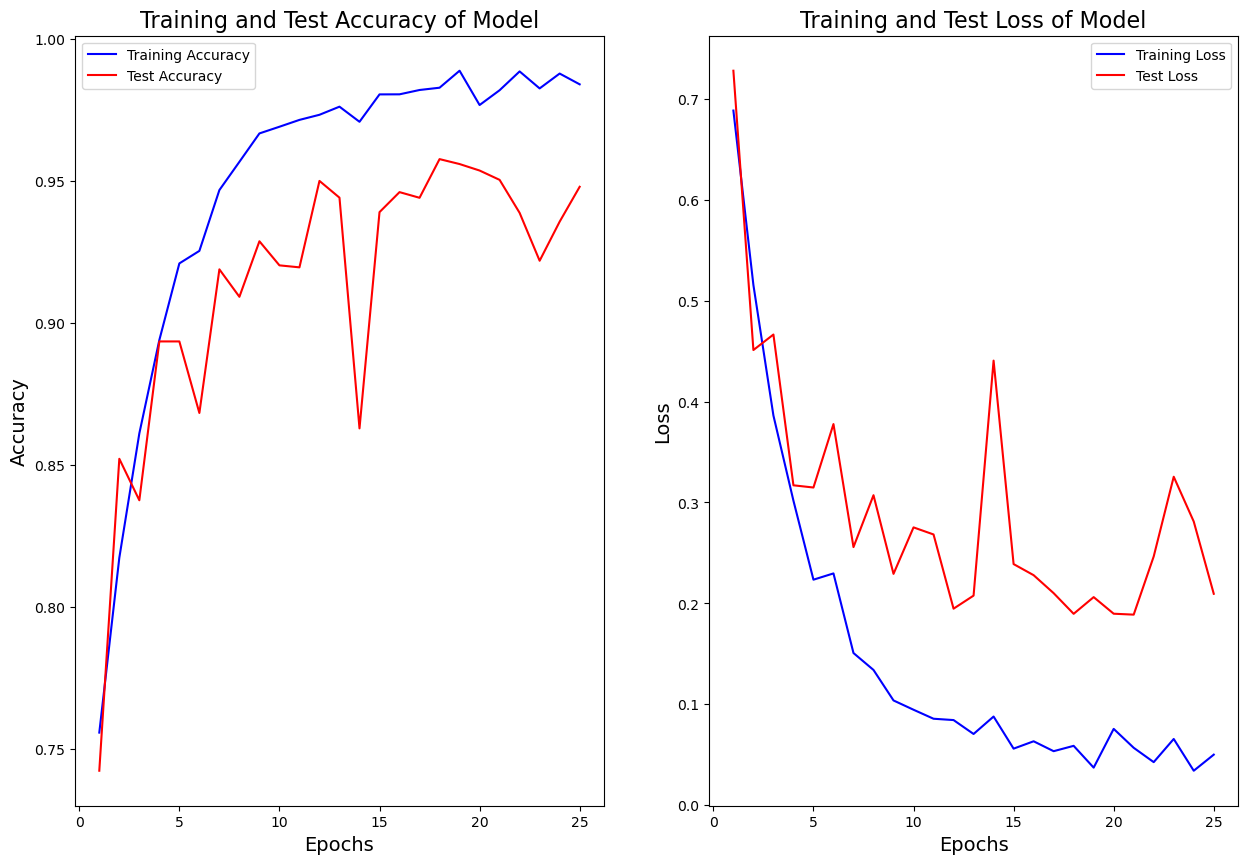

In [53]:
def plot_acc_loss(history, num_epochs):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    axes[0].plot(range(1, num_epochs+1), history['train_acc'], 'b', label='Training Accuracy')
    axes[0].plot(range(1, num_epochs+1), history['test_acc'], 'r', label='Test Accuracy')
    axes[0].set_title('Training and Test Accuracy of Model', fontsize=16)
    axes[0].set_xlabel('Epochs', fontsize=14)
    axes[0].set_ylabel('Accuracy', fontsize=14)
    axes[0].legend()
    
    axes[1].plot(range(1, num_epochs+1), history['train_loss'], 'b', label='Training Loss')
    axes[1].plot(range(1, num_epochs+1), history['test_loss'], 'r', label='Test Loss')
    axes[1].set_title('Training and Test Loss of Model', fontsize=16)
    axes[1].set_xlabel('Epochs', fontsize=14)
    axes[1].set_ylabel('Loss', fontsize=14)
    axes[1].legend()
    
    plt.show()

plot_acc_loss(history,num_epochs)


In [54]:
def accuracy(loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.996451541361721
Test Accuracy : 0.9532122905027933
Validation Accuracy : 0.9477360931435964


In [55]:
class_to_idx = {classes[i]: i for i in range(len(classes))}
idx_to_class = {v: k for k, v in class_to_idx.items()}
idx_to_class

{0: 'Bacterial_spot',
 1: 'Early_blight',
 2: 'Healthy',
 3: 'Late_blight',
 4: 'Mosiac_virus',
 5: 'Septoria_leaf_spot',
 6: 'YellowLeaf_curl'}

In [56]:
def predict(inputs):
    """
    This function predicts the predicted outputs for the given test input sample

    Parameters
    ------------
    inputs : tensor, float32
    test input sample

    Returns:
    -------------
    predicted: tensor, float32
    Predicitons for each class by the model 
    """
#     export_file = 'model_v1.pth'
#     model = torch.load(export_file).to(device)
    predicted = model(inputs.to(device))
    return predicted

In [57]:
from sklearn.metrics import confusion_matrix

# Get predicted labels and actual labels for all samples in the validation set
all_preds = []
all_labels = []
for sample, label in test_loader:
    pred = predict(sample)
    all_preds.extend(torch.argmax(pred, dim=-1).tolist())
    all_labels.extend(label.tolist())

# Build confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print(cm)


[[202   3   0   1   0   7   2]
 [  8 190   2   5   0   2   0]
 [  0   1 188   2   0   0   0]
 [  1   9   1 183   0   4   0]
 [  1   0   0   1 208   0   0]
 [  2   2   3   4   2 206   1]
 [  2   0   0   0   1   0 188]]


Text(0.5, 1.0, 'Confusion Matrix')

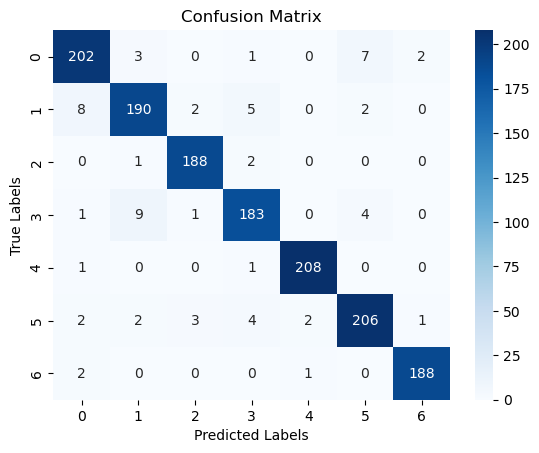

In [58]:
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Set the axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

In [59]:
from sklearn.metrics import classification_report

target_names = idx_to_class.values()

print(classification_report(all_labels, all_preds, target_names=target_names))

                    precision    recall  f1-score   support

    Bacterial_spot       0.94      0.94      0.94       215
      Early_blight       0.93      0.92      0.92       207
           Healthy       0.97      0.98      0.98       191
       Late_blight       0.93      0.92      0.93       198
      Mosiac_virus       0.99      0.99      0.99       210
Septoria_leaf_spot       0.94      0.94      0.94       220
   YellowLeaf_curl       0.98      0.98      0.98       191

          accuracy                           0.95      1432
         macro avg       0.95      0.95      0.95      1432
      weighted avg       0.95      0.95      0.95      1432



In [60]:
torch.save(model.state_dict(),'my_model_v100.pth')

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
c1.weight 	 torch.Size([32, 3, 3, 3])
c1.bias 	 torch.Size([32])
c2.weight 	 torch.Size([64, 32, 3, 3])
c2.bias 	 torch.Size([64])
c3.weight 	 torch.Size([64, 64, 3, 3])
c3.bias 	 torch.Size([64])
c4.weight 	 torch.Size([64, 64, 3, 3])
c4.bias 	 torch.Size([64])
c5.weight 	 torch.Size([64, 64, 3, 3])
c5.bias 	 torch.Size([64])
d1.weight 	 torch.Size([4096, 1024])
d1.bias 	 torch.Size([1024])
d2.weight 	 torch.Size([1024, 7])
d2.bias 	 torch.Size([7])
Optimizer's state_dict:
state 	 {0: {'step': tensor(7050.), 'exp_avg': tensor([[[[ 2.6063e-02,  2.9006e-02,  3.0232e-02],
          [ 2.6574e-02,  2.9478e-02,  3.0929e-02],
          [ 2.6108e-02,  2.8999e-02,  3.1240e-02]],

         [[ 1.5821e-02,  1.8874e-02,  2.0568e-02],
          [ 1.5881e-02,  1.8722e-02,  2.0660e-02],
          [ 1.5090e-02,  1.7955e-02,  2.0544e-02]],

         [[ 1.2598e-02,  1.6829e-02,  1.9521e-02],
          [ 1.3553e-02,  1.7976e-02,  2.0976e-02],
          [ 1.3568e-02,  1.8197e-02,  2.20

In [71]:
# Load the image
img_path = "/kaggle/input/tomato-custom-dataset/Plant/Late_blight/102.flipped.jpg"
image = Image.open(img_path).convert('RGB')

# Apply transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image = transform(image)

# Pass through the model
model.eval()
with torch.no_grad():
    image = image.to(device)  # Move input tensor to the GPU
    output = model(image.unsqueeze(0))  # Add batch dimension
predicted_probs = torch.softmax(output, dim=1)
predicted_class = torch.argmax(output, dim=1).item()
actual_class = idx_to_class[predicted_class]
confidence = predicted_probs[0][predicted_class].item()

# Print the predicted class and confidence
print('Predicted class:', actual_class)
print('Confidence:', confidence)


Predicted class: Late_blight
Confidence: 0.9999885559082031
